In [153]:
# Cargo librerías

import numpy  as np  
import pandas as pd

# Leo y guardo el archivo en formato dataframe

full_df = pd.read_csv('C:/Users/Victor/Desktop/machine learning/machine-learning/project/airbnb-listings.csv', sep=';')

# Elimino las variables que, por conocimiento del fichero, sé que no van a ser útiles para un problema de estimación del 
# precio con regresión: id's, url´s, campos de texto abiertos de carácter descriptivo/comentarios, variables repetidas o
# redundantes

columnstodrop1 = ["ID", "Listing Url", "Scrape ID", "Last Scraped", "Name", "Summary", "Space", "Description"
                ,"Experiences Offered" , "Neighborhood Overview", "Notes", "Transit", "Access", "Interaction", "House Rules"
                , "Thumbnail Url", "Medium Url" , "Picture Url", "XL Picture Url", "Host ID", "Host URL", "Host Name"
                , "Host About", "Host Response Time" , "Host Thumbnail Url", "Host Picture Url", "Host Neighbourhood"
                , "Host Verifications", "Street", "Neighbourhood", "Smart Location", "Country Code", "Country"
                , "Calendar Updated", "Has Availability" , "Calendar last Scraped", "First Review", "Last Review"
                , "License", "Jurisdiction Names", "Features"]

full_df = full_df.drop(columnstodrop1,axis=1)

In [154]:
# Filtro el dataframe para quedarme con los casos de Madrid, hay varias variables con info relativa a esta cuestión.
# Tras realizar un pequeño análisis concluyo que la variable "Market" es la  que mejor categoriza la localización.
# Filtro el dataframe por "Market = Madrid" y elimino después todas las  variables.
# Hago esto antes de dividir en train y test para evitar desajustes (nº muestras) posteriores a causa de estre filtrado.

full_df[["Host Location", "City", "State", "Market"]].value_counts()
full_df[["Host Location", "City", "State", "Market"]].describe()
full_df[["City", "Market"]].value_counts()
full_df[["Market", "City"]].value_counts()

madrid_df = full_df[full_df["City"] == "Madrid"]
madrid_df = madrid_df.drop(["Host Location", "City", "State", "Market"], axis=1)

In [155]:
# Cargo librerías y funciones para separar los conjuntos de test y train, hago el split

from sklearn.model_selection import train_test_split

# Divido en train/test

mad_train, mad_test = train_test_split(madrid_df, test_size=0.25, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {mad_train.shape}')
print(f'Dimensiones del dataset de test: {mad_test.shape}')

Dimensiones del dataset de training: (9905, 44)
Dimensiones del dataset de test: (3302, 44)


In [156]:
# Comienzo un mix de análisis exploratorio y preprocesamiento, con objeto de eliminar variables que no aporten al modelo.

mad_train.head()
mad_train.describe
mad_train.dtypes
mad_train.isna().sum()

# Elimino variables que no aportan valor al modelo: "Host Since", "Host Response Rate" y "Geolocation".
# Además elimino aquellas variables que tienen muchos valores nulos: "Host Acceptance Rate", "Square Feet",  "Weekly Price"
# (correlada además con el precio) y "Monthly Price" (correlada además con el precio)

mad_train = mad_train.drop(["Host Since", "Host Response Rate", "Geolocation", "Host Acceptance Rate", "Square Feet"
                           ,"Weekly Price", "Monthly Price"], axis=1)

In [157]:
# Analizo las variables de tipo object para su codifacación

mad_train.dtypes

counts_value = ["Neighbourhood Cleansed", "Neighbourhood Group Cleansed", "Zipcode", "Property Type", "Room Type", "Bed Type"
               , "Amenities", "Cancellation Policy"]
for v in counts_value:
    print(mad_train[v].value_counts())

# Elimino "Amenities" por tratarse de una variable con miles de categorías (combinaciones múltiples de ítems)

mad_train = mad_train.drop("Amenities", axis=1)

# Cargo librerías

from sklearn.preprocessing import LabelEncoder

# Codifico las variables de tipo object con un LabelEncoder para cada variable con objeto de que no haya 
# diferencias train/test por ausencia de alguna de las categorías en test

NC_le = LabelEncoder()
NGC_le = LabelEncoder()
Z_le = LabelEncoder()
PT_le = LabelEncoder()
RT_le = LabelEncoder()
BT_le = LabelEncoder()
CP_le = LabelEncoder()

mad_train["Neighbourhood Cleansed"] = NC_le.fit_transform(mad_train["Neighbourhood Cleansed"])
mad_train["Neighbourhood Group Cleansed"] = NGC_le.fit_transform(mad_train["Neighbourhood Group Cleansed"])
mad_train["Zipcode"] = Z_le.fit_transform(mad_train["Zipcode"])
mad_train["Property Type"] = PT_le.fit_transform(mad_train["Property Type"])
mad_train["Room Type"] = RT_le.fit_transform(mad_train["Room Type"])
mad_train["Bed Type"] = BT_le.fit_transform(mad_train["Bed Type"])
mad_train["Cancellation Policy"] = CP_le.fit_transform(mad_train["Cancellation Policy"])

Embajadores    1402
Universidad    1044
Palacio         842
Sol             690
Justicia        581
               ... 
Orcasitas         2
El Plantío        2
El Goloso         2
Pavones           1
Rosas             1
Name: Neighbourhood Cleansed, Length: 125, dtype: int64
Centro                   5100
Chamberí                  714
Salamanca                 658
Arganzuela                574
Tetuán                    345
Retiro                    329
Moncloa - Aravaca         320
Carabanchel               285
Latina                    268
Chamartín                 267
Ciudad Lineal             214
Puente de Vallecas        161
Hortaleza                 136
Fuencarral - El Pardo     120
Usera                     108
San Blas - Canillejas      80
Villaverde                 60
Moratalaz                  57
Barajas                    55
Villa de Vallecas          29
Vicálvaro                  25
Name: Neighbourhood Group Cleansed, dtype: int64
28012    1552
28004    1340
28005     902
280

In [158]:
# Realizo un análisis de correlación entre variables con objeto de eliminar variables muy correladas entre sí

mad_train.corr()

# Elimino las variables altamente correladas (dejamos una variable por juego de variables correladas): "Host Listings 
# Count-Host Total Listings Count-Calculated host listings count", "Availability 30-Availability 60-Availability 90", 
# "Review Scores Rating-Review Scores Value"

# Ekimino también "Longitude" y "Latitude", quedándome con "Zipcode" como referencia de localización.

mad_train = mad_train.drop(["Host Listings Count", "Host Total Listings Count", "Availability 60", "Availability 90", "Review Scores Value", "Longitude", "Latitude"], axis=1)

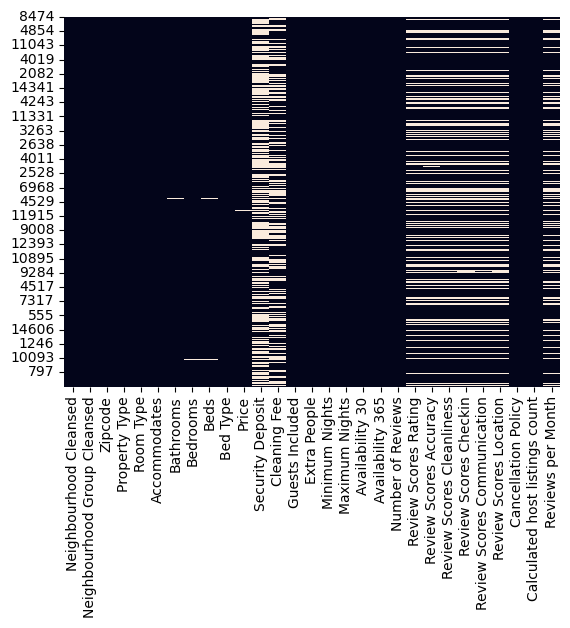

In [159]:
# Cargo librerías

import seaborn as sns

# Visualizo NA's

mad_train.isna().sum()
sns.heatmap(mad_train.isnull(), cbar=False)

# Imputo NA's

list_natransformto_mean = ['Bathrooms', 'Bedrooms', 'Beds', 'Review Scores Rating'
                          ,'Review Scores Accuracy', 'Review Scores Cleanliness'
                          ,'Review Scores Checkin', 'Review Scores Communication'
                          ,'Review Scores Location', 'Reviews per Month', 'Price']

for v in list_natransformto_mean:
    mad_train[v].fillna(mad_train[v].mean(), inplace=True)

list_natransformto_zero = ['Security Deposit', 'Cleaning Fee']

for v in list_natransformto_zero:
    mad_train[v].fillna(0, inplace=True)

In [160]:
# Cargo librerías

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Reordeno columnas del dataset para dejar "Price" en último lugar

mad_train = mad_train.reindex(columns=['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Zipcode',
       'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Cancellation Policy',
       'Calculated host listings count', 'Reviews per Month', 'Price'])

# Guardo el nombre de las columnas predictoras para futuras visualizaciones

feature_names = mad_train.columns[:-1]

# Normalizo

scaler = StandardScaler().fit(mad_train)
mad_train_normalized = scaler.transform(mad_train)

# Divido entre conjunto de variables predictoras ("x") y variable a predecir ("y")

x = mad_train_normalized[:,:-1]
y = mad_train_normalized[:,-1]

In [161]:
#Cargo librerías

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Utilizo Lasso para selección de características.
# Busco los mejores parámetros con GridSearchCV.

n_alphas = 20
alpha_vector = np.logspace(-5,1,n_alphas)
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid={'alpha': alpha_vector }, cv = 3)
grid.fit(x, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: -0.477
best parameters: {'alpha': 0.003359818286283781}


In [162]:
# Encontrados los mejores parámetros los utilizo con Lasso y observo el peso de las características

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(x,y)
w = lasso.coef_

for f,wi in zip(feature_names,w):
    print(f,wi)

Neighbourhood Cleansed 0.010282137902895257
Neighbourhood Group Cleansed -0.0
Zipcode -0.048756950844052134
Property Type 0.0019251387951384384
Room Type -0.24048588546166177
Accommodates 0.21566259543984614
Bathrooms 0.1478743299342376
Bedrooms 0.18075452848539225
Beds 0.0079144995711155
Bed Type 0.002454322758054687
Security Deposit 0.0
Cleaning Fee 0.2466458016573217
Guests Included -0.0
Extra People -0.06317637095230623
Minimum Nights -0.0
Maximum Nights -0.0
Availability 30 0.11813328582774715
Availability 365 0.0009279904257695182
Number of Reviews -0.03678291870465405
Review Scores Rating 0.027333643142551087
Review Scores Accuracy 0.019770023558956816
Review Scores Cleanliness 0.026802796121953857
Review Scores Checkin -0.004926113441883984
Review Scores Communication -0.030089965664386
Review Scores Location 0.05348253539515729
Cancellation Policy -0.0401789064628883
Calculated host listings count 0.002211631384166855
Reviews per Month -0.032367000464273335


In [163]:
# Guardo las carácterísticas que Lasso ha llevado a cero para eliminarlas del modelo

features_todelete1 = []
for f,wi in zip(feature_names,w):
    if abs(wi) == 0:
        features_todelete1.append(f)       

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=4; total time=   0.3s
[CV] END ........................................max_depth=4; total time=   0.3s
[CV] END .......................................

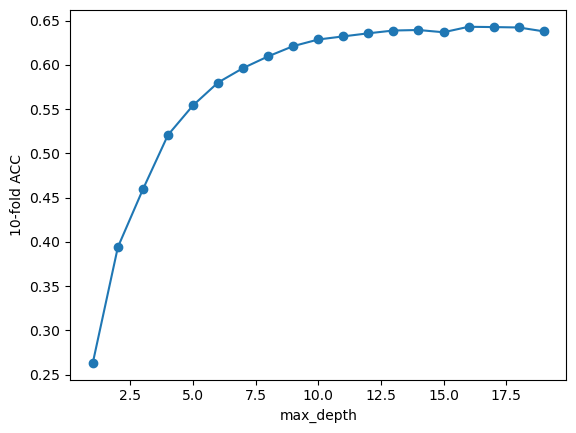

In [164]:
# Sigo teniendo muchas características, adicionalmente aplico random forest para selección de las mismas.
# Cargo librerías

from sklearn.ensemble import RandomForestRegressor

# Busco los mejores parámetros con GridSearchCV.

maxDepth = range(1,20)
n_estimators = 100
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=n_estimators, max_features='sqrt'), param_grid=tuned_parameters,cv=3, verbose=2) 
grid.fit(x, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Train:  0.9245513728576626


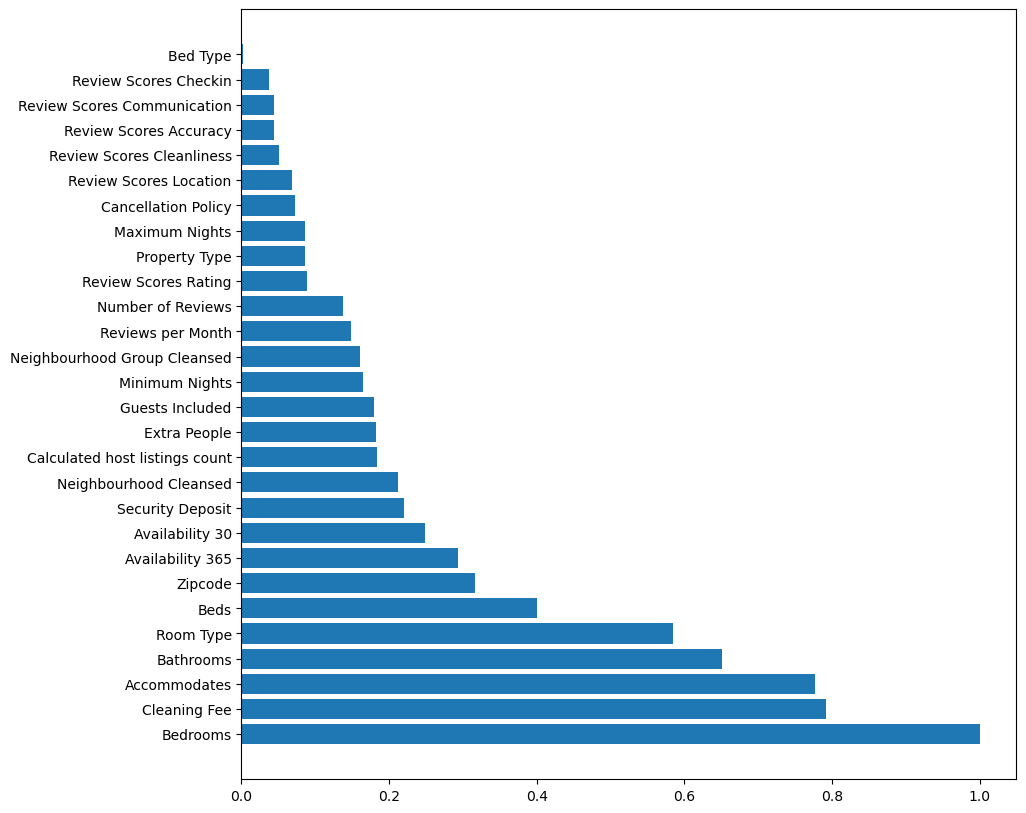

In [165]:
# Aplico random forest con los parámetros óptimos

maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=100,max_features='sqrt').fit(x,y)
print("Train: ",rf.score(x,y))

# Visualizo las características y sus aportaciones al modelo

importances = rf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(x.shape[1]),importances[indices])
plt.yticks(range(x.shape[1]),feature_names[indices])
plt.show()

In [166]:
# Decido establecer el corte en "Number of Reviews" y elimino las características con peso inferior.

features_todelete2 = ["Bed Type", "Review Scores Checkin", "Review Scores Accuracy", "Review Scores Communication",
                     "Review Scores Cleanliness", "Review Scores Location", "Maximum Nights", "Property Type", 
                     "Cancellation Policy"]

# Tras los procesos de selección, listo las características a eliminar del modelo y las saco del dataset

features_todelete = features_todelete1 + features_todelete2
mad_train = mad_train.drop(features_todelete, axis=1)

# Tras la selección, veo y guardo en una lista las características que utilizaremos en los modelos

features_tomodel = list(mad_train.columns)

In [168]:
# Doy por finalizado el análisis exploratorio y el pre-procesamiento. Resumo todos los pasos en esta celda, con objeto
# de agrupar en una misma ejecución todos los pasos previos al modelado.

# Cargo librerías

import numpy  as np  
import pandas as pd

# Leo y guardo el archivo en formato dataframe

full_df = pd.read_csv('C:/Users/Victor/Desktop/machine learning/machine-learning/project/airbnb-listings-extract.csv', sep=';')

# Filtro los casos para Madrid

madrid_df = full_df[full_df["City"] == "Madrid"]

# Filtro el dataframe para las características que utilizaremos en los modelos

madrid_df = madrid_df[features_tomodel]

# Codifico las variables de tipo object

NC_le = LabelEncoder()
Z_le = LabelEncoder()
RT_le = LabelEncoder()

madrid_df["Neighbourhood Cleansed"] = NC_le.fit_transform(madrid_df["Neighbourhood Cleansed"])
madrid_df["Zipcode"] = Z_le.fit_transform(madrid_df["Zipcode"])
madrid_df["Room Type"] = RT_le.fit_transform(madrid_df["Room Type"])

# Imputo NA's

list_natransformto_mean = ['Bathrooms', 'Bedrooms', 'Beds', 'Review Scores Rating', 'Reviews per Month', 'Price']

for v in list_natransformto_mean:
    madrid_df[v].fillna(madrid_df[v].mean(), inplace=True)

list_natransformto_zero = ['Cleaning Fee']

for v in list_natransformto_zero:
    madrid_df[v].fillna(0, inplace=True)

# Preparamos los datos para train/test

features = madrid_df.columns.drop(['Price'])
X = madrid_df[features].values
y = madrid_df['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state=0)

# Normalizo con los datos de train

scaler = StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

best mean cross-validation score: 0.512
best parameters: {'max_depth': 6}


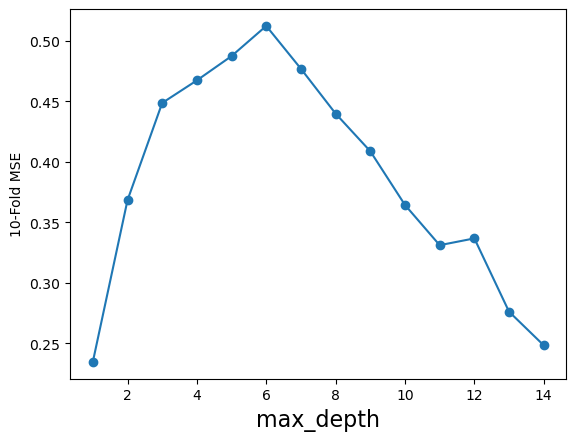

Train:  0.6468779521066703
Test:  0.5140990337811198


In [171]:
# Empiezo con los modelos, busco los valores óptimos para decision tree

from sklearn.tree import DecisionTreeRegressor

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 3)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

# Una vez encontrados los valores óptimos, aplico el modelo y obtengo las prestaciones

maxDepthOptimo = grid.best_params_['max_depth'] 
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(XtrainScaled, y_train)

print("Train: ",treeModel.score(XtrainScaled, y_train))
print("Test: ",treeModel.score(XtestScaled,y_test))

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END ........................................max_depth=4; total time=   0.2s
[CV] END ........................................max_depth=4; total time=   0.2s
[CV] END .......................................

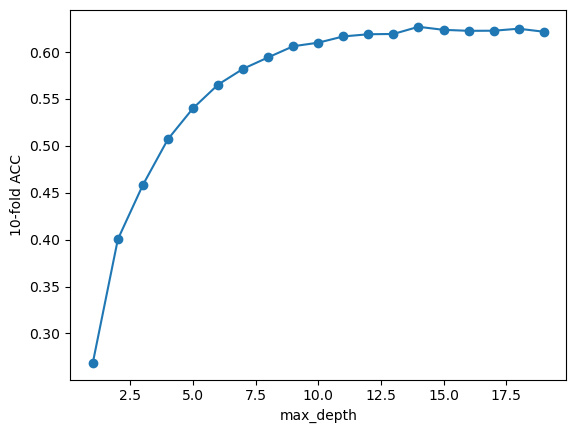

Train:  0.9012548683474144
Test:  0.6863157608307867


In [172]:
# Pruebo con otro modelo, random forest, busco sus valores óptimos

maxDepth = range(1,20)
n_estimators = 100
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=n_estimators, max_features='sqrt'), param_grid=tuned_parameters,cv=3, verbose=2) 
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

# Una vez encontrados los valores óptimos, aplico el modelo y obtengo las prestaciones

maxDepthOptimo = grid.best_params_['max_depth']
rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=100,max_features='sqrt').fit(XtrainScaled, y_train) 

print("Train: ",rf.score(XtrainScaled, y_train))
print("Test: ",rf.score(XtestScaled,y_test))

In [173]:
# Cargo librerías

from sklearn.ensemble import GradientBoostingRegressor

# Pruebo con otro modelo, boosted trees, busco sus valores óptimos

Niterations = [500,1000,1500]
learningRate = [0.1,0.05]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth = 3), param_grid=param_grid, cv = 3)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Una vez encontrados los valores óptimos, aplico el modelo y obtengo las prestaciones

lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(XtrainScaled, y_train)

print("Train:",bt.score(XtrainScaled, y_train))
print("Test:",bt.score(XtestScaled,y_test))

best mean cross-validation score: 0.627
best parameters: {'learning_rate': 0.05, 'n_estimators': 500}
Train: 0.7465903036984242
Test: 0.6739115372533917


best mean cross-validation score: -1527.419
best parameters: {'alpha': 0.14677992676220705}


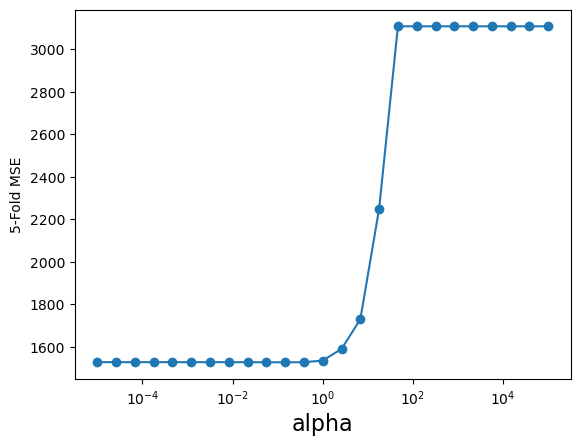

R2 Score en test: 0.5528074275936657


In [174]:
# Cargo librerías

from sklearn.metrics import r2_score

# Pruebo un último modelo, Lasso. Busco sus valores óptimos.

alpha_vector = np.logspace(-5,5,25)
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid={'alpha': alpha_vector }, cv = 3)
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

# Una vez encontrados los valores óptimos, aplico el modelo y obtengo las prestaciones

lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

y_hat_test = lasso.predict(XtestScaled)

print( 'R2 Score en test:', r2_score(y_test, y_hat_test))

In [179]:
### Conclusión

print("""Muy sorprendido, pese a las múltiples advertencias, de la cantidad de tiempo que se lleva la preparación de datos previa a la implementación de modelos. En mi caso la proporción habrá sido de un 90-10.

He disfrutado mucho el módulo, lástima no poder alargar/profundizar una par de semanas más - hay otros módulos que, y es algo hablado con más compañeras, no nos están resultando muy útiles -.

El formato de la práctica es un acierto, un problema real de principio a fin, sin muchas pautas. Está muy bien para poner en práctica lo aprendido en módulos anteriores, integrarlo y unirlo con lo aprendido en este módulo.

Y poco más, me habría gustado poder dedicar más tiempo a cacharrear los materiales y a la práctica, pero voy con la lengua fuera. Volveré a revisitar los vídeos de las clases y los materiales a futuro, eso seguro.

Quedo atento a las correcciones, seguro que alguna habrá, y le pego una vuelta o re-entrego si fuera necesario""")



Muy sorprendido, pese a las múltiples advertencias, de la cantidad de tiempo que se lleva la preparación de datos previa a la implementación de modelos. En mi caso la proporción habrá sido de un 90-10.

He disfrutado mucho el módulo, lástima no poder alargar/profundizar una par de semanas más - hay otros módulos que, y es algo hablado con más compañeras, no nos están resultando muy útiles -.

El formato de la práctica es un acierto, un problema real de principio a fin, sin muchas pautas. Está muy bien para poner en práctica lo aprendido en módulos anteriores, integrarlo y unirlo con lo aprendido en este módulo.

Y poco más, me habría gustado poder dedicar más tiempo a cacharrear los materiales y a la práctica, pero voy con la lengua fuera. Volveré a revisitar los vídeos de las clases y los materiales a futuro, eso seguro.

Quedo atento a las correcciones, seguro que alguna habrá, y le pego una vuelta o re-entrego si fuera necesario
